# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import streamlit as st

# Coleta e tratamento de dados

In [2]:
# Coleta de dados
df = pd.read_csv('~/repos/House-Rocket-Analytics/House Sales in King County.csv')

# Elimina imóveis duplicados
df = df.drop_duplicates(subset=['id']).copy(deep=True).reset_index(drop=True)

# Remove a exibição de notação científica
pd.set_option('float_format', '{:.2f}'.format)

# Arredonda duas casas decimais
pd.set_option('display.precision', 2)

# redefine as dimensões dos gráficos deste notebook
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [3]:
# Trata datas inválidas

# Converte para formato YYYY-MM-DD
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

# Converte de 'int' para 'datetime' no formato YYYY-MM-DD
df['yr_built'] = df['yr_built'].astype(str)
df['yr_built'] = pd.to_datetime(df['yr_built']).dt.strftime('%Y')

df['yr_renovated'] = df['yr_renovated'].astype(str)
df['yr_renovated'] = df['yr_renovated'].replace('0', '1900') # PREMISSA: quando não há reforma, ano da reforma é '1900'
df['yr_renovated'] = pd.to_datetime(df['yr_renovated']).dt.strftime('%Y')

In [4]:
# Converte do tipo float64 para int
df['bathrooms'] = df['bathrooms'].astype(int)
df['floors'] = df['floors'].astype(int)

# repare como esse procedimento de conversão de tipos se repete
# ele pode virar uma função que converte tipos exceto datetime
# entrada: df, column, result_type
# saída: none

In [5]:
# Identificando outliers

# Análise descritiva:
# exibe o máximo e mínimo de cada coluna para interpretação
num_attributes = df.select_dtypes(include=['int64', 'float64'])
maxim = pd.DataFrame(num_attributes.apply(np.max))
minim = pd.DataFrame(num_attributes.apply(np.min))
df1 = pd.concat([maxim, minim], axis=1).reset_index()
df1.columns = ['ATTRIBUTES', 'MAX', 'MIN']
#print(df1)

# Verificando se as outras características do imóvel com 33 quartos são compatíveis
df.loc[df['bedrooms'] == df['bedrooms'].max(), ['id', 'bedrooms', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement']]
df.loc[df['bedrooms'] == 33, 'bedrooms'] = 3 # PREMISSA: o '33' foi erro de digitação. O correto é '3'

# Verificando hipóteses

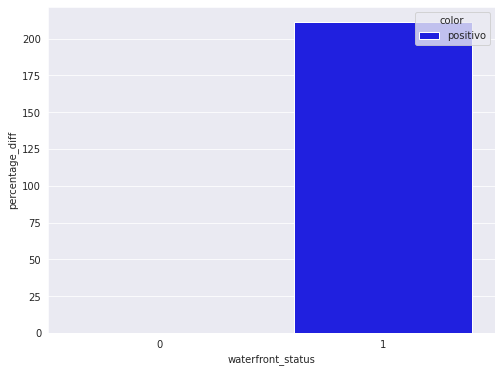

In [6]:
# HIPÓTESE 01 - IMÓVEIS COM VISTA PARA ÁGUA SÃO 30% MAIS CAROS

df1 = df[['price', 'waterfront']].groupby('waterfront').median().reset_index()
df1.columns = ['waterfront_status', 'median_price']

# -----------------------------------------------------------
# ISSO AQUI VAI VIRAR FUNÇÃO
# utilizando a função pct para mostrar a diferença %
df1['percentage_diff'] = (df1['median_price'].pct_change())*100
df1['color'] = df1['percentage_diff'].apply(lambda x: 'negativo' if x < 0 else 'positivo')

# plotando
sns.set_style('darkgrid')
color = ['blue', 'red']
ax = sns.barplot(x = 'waterfront_status', y = 'percentage_diff', data = df1, hue='color', palette = color)
ax.ticklabel_format(style = 'plain', axis = 'y') # remove a notação científica do eixo y
plt.show()

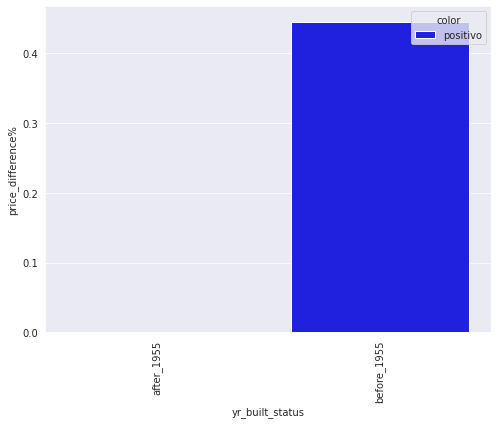

In [11]:
# HIPÓTESE 02 - Imóveis construídos antes de 1955 são 50% mais baratos, em média.

df1 = df[['price', 'yr_built']].copy().reset_index()
df1.loc[df1['yr_built'] < '1955', 'yr_built_status'] = 'before_1955'
df1.loc[df1['yr_built'] >= '1955', 'yr_built_status'] = 'after_1955'

df2 = df1[['price', 'yr_built_status']].groupby('yr_built_status').median().reset_index()

#-----------------------------------
# ISSO AQUI VAI VIRAR FUNÇÃO
# utilizando a função pct para mostrar a diferença %
df2['price_difference%'] = (df2['price'].pct_change())*100.0
df2['color'] = df2['price_difference%'].apply(lambda x: 'negativo' if x < 0 else 'positivo')

# plotando
sns.set_style('darkgrid')
color = ['blue', 'red']
sns.barplot(x = 'yr_built_status', y = 'price_difference%', data = df2, hue='color', palette = color)
plt.xticks(rotation=90) # rotaciona a legenda do eixo X em 90 graus.
plt.show()

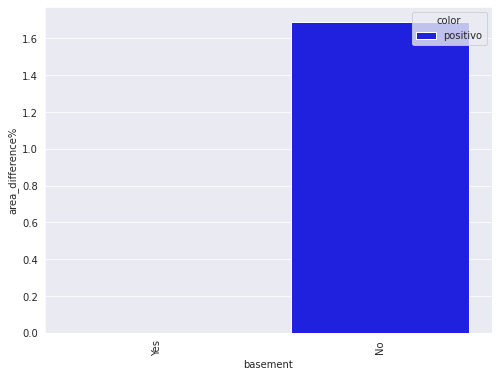

In [27]:
# HIPÓTESE 03 - Imóveis sem porão têm área total 40% maior que imóveis com porão.

df1 = df[['sqft_lot', 'sqft_basement']].copy().reset_index()
df1['basement'] = 'No'
df1.loc[df1['sqft_basement'] > 0, 'basement'] = 'Yes'

df2 = df1[['sqft_lot', 'basement']].groupby('basement', sort=False).median().reset_index()
df2 = df2.sort_values(by='sqft_lot')


#-----------------------------------
# ISSO AQUI VAI VIRAR FUNÇÃO
# utilizando a função pct para mostrar a diferença %
df2['area_difference%'] = (df2['sqft_lot'].pct_change())*100.0
df2['color'] = df2['area_difference%'].apply(lambda x: 'negativo' if x < 0 else 'positivo')

# plotando
sns.set_style('darkgrid')
color = ['blue', 'red']
sns.barplot(x = 'basement', y = 'area_difference%', data = df2, hue='color', palette = color)
plt.xticks(rotation=90) # rotaciona a legenda do eixo X em 90 graus.
plt.show()

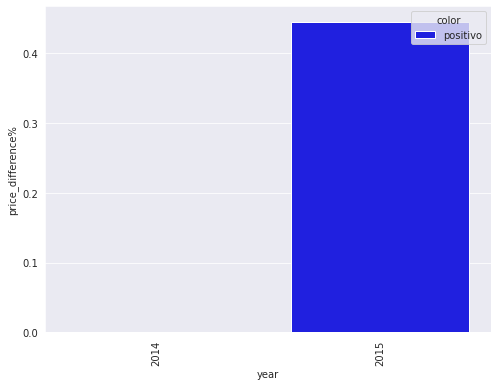

In [28]:
# HIPÓTESE 04 - O crescimento dos preços YoY é de 10%

df1 = df[['date', 'price']].copy().reset_index()

# transformar 'date' em um valor apenas com o ano
df1['year'] = pd.to_datetime(df1['date']).dt.strftime('%Y')

# agrupar por ano
df2 = df1[['year', 'price']].groupby('year').median().reset_index()

# ISSO AQUI VAI VIRAR FUNÇÃO
# utilizando a função pct para mostrar a diferença %
df2['price_difference%'] = (df2['price'].pct_change())*100.0
df2['color'] = df2['price_difference%'].apply(lambda x: 'negativo' if x < 0 else 'positivo')

# plotando
sns.set_style('darkgrid')
color = ['blue', 'red']
sns.barplot(x = 'year', y = 'price_difference%', data = df2, hue='color', palette = color)
plt.xticks(rotation=90) # rotaciona a legenda do eixo X em 90 graus.
plt.show()

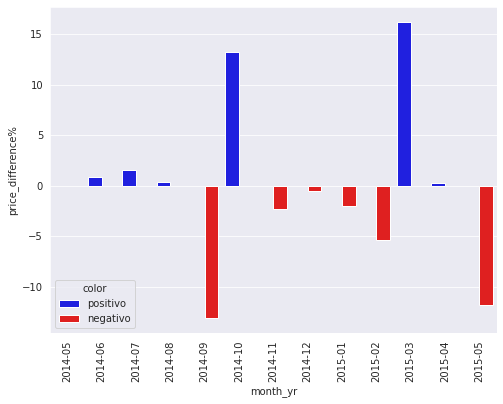

In [29]:
#HIPÓTESE 05 - Imóveis com 03 banheiros têm crescimento de preço MoM de 15%.

df1 = df[['price', 'bathrooms', 'date']].copy()

df1 = df1[df1['bathrooms'] == 3].reset_index(drop=True) # montar um df apenas com imóveis com 03 banheiros

# cria coluna mês do ano: YYYY-mm
df1['month_yr'] = pd.to_datetime(df1['date']).dt.strftime('%Y-%m')

# agrupar por data
df2 = df1[['month_yr', 'price']].groupby('month_yr').median().reset_index()

# utilizando a função pct para mostrar a diferença %
df2['price_difference%'] = (df2['price'].pct_change())*100
df2['color'] = df2['price_difference%'].apply(lambda x: 'negativo' if x < 0 else 'positivo')

# plotando
sns.set_style('darkgrid')
color = ['blue', 'red']
sns.barplot(x = 'month_yr', y = 'price_difference%', data = df2, hue='color', palette = color)
plt.xticks(rotation=90) # rotaciona a legenda do eixo X em 90 graus.
plt.show()

# Perguntas do CEO

In [11]:
df1 = df.copy()

## 1. Quais imóveis a House Rocket deveria comprar? Por qual preço?

In [12]:
# Obter o preço por m2
# m2 = sqft/10,764

df1['price_m2'] = 0.0
df1['price_m2'] = df1['price']*10.764
df1['price_m2'] = df1['price_m2']/df1['sqft_lot']

In [205]:
# Agrupar os imóveis por zipcode, mês do ano e condition
# e obter o preço por m2 mediano

df1['month'] = pd.to_datetime(df1['date']).dt.strftime('%m')

df2 = df1[['month', 'price_m2', 'zipcode', 'condition']].groupby(['zipcode', 'month', 'condition']).median().reset_index()
df2 = df2.rename(columns={'price_m2':'median_price_m2_by_month_zipcode_condition'})
#df2.sort_values(by='median_price_m2_by_month_zipcode_condition', ascending=False)


df3 = pd.merge(df1, df2, on=['zipcode', 'month', 'condition'], how='inner')
df3[['id', 'date', 'price', 'zipcode', 'price_m2', 'month', 'condition','median_price_m2_by_month_zipcode_condition']].sample(5)

,id,date,price,zipcode,price_m2,month,condition,median_price_m2_by_month_zipcode_condition
13950,8133300050,2014-06-26,200500.00,98030,230.92,06,4,279.74
3461,7202341110,2015-03-13,702000.00,98053,1285.96,03,3,492.65
18430,6329000385,2014-06-18,825000.00,98146,906.89,06,3,394.39
21008,3468800310,2015-01-13,425000.00,98108,1143.67,01,2,1143.67
2663,1672000170,2014-09-08,575000.00,98006,555.54,09,4,739.97


In [206]:
# comparar o price_m2 com median_price_m2_by_month_and_zipcode
# comprar aqueles com mais de 30% de desconto em relação à mediana E com condições regulares
for i in range(len(df3)):
    if (df3.loc[i,'price_m2'] < (0.7* df3.loc[i,'median_price_m2_by_month_zipcode_condition'])) & (df3.loc[i, 'condition'] > 2):
        df3.loc[i, 'status'] = 'buy'
        df3.loc[i, 'buy_price'] = df3.loc[i, 'price']
    else:
        df3.loc[i, 'status'] = 'not buy'
        df3.loc[i, 'buy_price'] = 0.0

In [207]:
df3 = df3.drop(columns=['sqft_lot15', 'sqft_living15', 'view', 'grade'])
df3.to_csv('/media/joaomarcos/Ubuntu-data/repos/House-Rocket-Analytics/houses_cleaned.csv')

## 2. Uma vez comprado, quando a House Rocket deveria vender o imóvel? Por qual preço?

In [208]:
# Se o imóvel foi comprado (status buy)
# Ela deve vendê-los se o preço mediano for 50% MAIOR que o preço de compra

# mudar status para 'sold' 
# criar coluna 'sell price' com o valor de venda ou 0
df3 = pd.read_csv('/media/joaomarcos/Ubuntu-data/repos/House-Rocket-Analytics/houses_cleaned.csv')

for i in range(len(df3)):
    if (df3.loc[i, 'status'] == 'buy') & (df3.loc[i,'price_m2'] <= (0.5 * df3.loc[i,'median_price_m2_by_month_zipcode_condition'])):
        df3.loc[i, 'status'] = 'sell'
        df3.loc[i, 'sell_price'] = df3.loc[i,'median_price_m2_by_month_zipcode_condition'] * df3.loc[i, 'sqft_lot']
    else:
        df3.loc[i, 'sell_price'] = 0.0

In [209]:
df3.loc[df3['condition'] > 2, ['id', 'date', 'month', 'zipcode','price_m2', 'median_price_m2_by_month_zipcode_condition', 'status', 'buy_price', 'sell_price']].sample(10)

,id,date,month,zipcode,price_m2,median_price_m2_by_month_zipcode_condition,status,buy_price,sell_price
11949,3346300356,2015-03-18,3,98056,1059.22,819.93,not buy,0.00,0.00
9855,5127000810,2014-05-14,5,98059,322.39,317.94,not buy,0.00,0.00
17983,4443800940,2015-04-08,4,98117,1345.50,1680.67,not buy,0.00,0.00
13690,7853300720,2015-02-12,2,98065,754.68,874.03,not buy,0.00,0.00
1006,1934800087,2014-06-26,6,98122,3931.81,2150.69,not buy,0.00,0.00
11987,638100073,2014-06-02,6,98059,266.65,813.60,sell,327000.00,10739579.51
330,3861500330,2015-04-30,4,98003,365.11,319.06,not buy,0.00,0.00
141,7686204750,2015-01-21,1,98198,273.67,360.91,not buy,0.00,0.00
974,7974200776,2014-12-05,12,98115,1681.88,1271.26,not buy,0.00,0.00
5940,1724079013,2014-07-18,7,98024,26.14,62.45,sell,529000.00,13602493.20


In [210]:
df3.to_csv('/media/joaomarcos/Ubuntu-data/repos/House-Rocket-Analytics/purchase_recom.csv')

In [211]:
# cria tabela totalizando o resultado financeiro da operação:
# número de imóveis vendidos, custo total, faturamento total e lucro total

df4 = df3[['price', 'status', 'sell_price']].groupby('status').sum().reset_index()

df5 = pd.DataFrame(columns=['houses_sold', 'total_cost', 'total_revenue', 'total_profit'])
df5['total_cost'] = df4.loc[df4['status'] == 'buy', 'price'].reset_index(drop=True)
df5['total_revenue'] = df4.loc[df4['status'] == 'sell', 'sell_price'].reset_index(drop=True)
df5['total_profit'] = df5['total_revenue'] - df5['total_cost']

# value_counts retorna um series com o total da frequência de cada valor da coluna
# eu quero o terceiro item desse series
df5['houses_sold'] = df3['status'].value_counts()[2]

# Salva a tabela do resultado financeiro total
df5.to_csv('/media/joaomarcos/Ubuntu-data/repos/House-Rocket-Analytics/financial_result.csv')

,houses_sold,total_cost,total_revenue,total_profit
0,2336,1105974588.00,66839914416.54,65733939828.54
